# DQN (Roy Debugging Playground)

# Import the Libraries

In [1]:
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.optimize import minimize

from PortfolioRebalancerEnv_Roy import PortfolioRebalancerEnv
import seaborn as sns
import os

import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.express as px

from sklearn.metrics import confusion_matrix

# Create Replay Memory Class

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Create Q-Network

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, name, tc, chkpt_dir='results/models'):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, n_actions)

        self.checkpoint_file = os.path.join(chkpt_dir, name + f'_tc_{tc}_assets_{n_observations}_dqn')

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

In [4]:
def net_sharpe(w1, mu, cov, w0, tc):
    return (w1.dot(mu) - cost_turnover(w0, w1, tc)) / np.sqrt(w1.dot(cov).dot(w1.T))


def obj_func(x, mu, cov):
    return -x.dot(mu) / np.sqrt(x.dot(cov).dot(x))

def find_optimal_wgt(mu, cov):

    n = len(mu)
    w_min = np.zeros(n)
    w_max = np.ones(n) * 2 / n
    x0 = np.ones(n) / n
    bounds = np.vstack([w_min, w_max]).T

    cstr = [{"type": "eq", "fun": lambda x: np.sum(x) - 1, "jac": lambda x: np.ones(n)}]
    opt = minimize(fun=obj_func, x0=x0, args=(mu, cov),
                   bounds=bounds,
                   constraints=cstr,
                   tol=1e-6,
                   options={"maxiter": 10000})

    if not opt.success:
        raise ValueError("optimization failed: {}".format(opt.message))

    return opt.x / opt.x.sum()


def cost_turnover(w0, w1, tc):
    return np.sum(np.abs(w1 - w0) * tc) / 2


def expected_cost_total(w0, w1, opt_w, mu, cov, tc):
    opt_net_sharpe = net_sharpe(opt_w, mu, cov, w0, tc)
    w1_net_sharpe = net_sharpe(w1, mu, cov, w0, tc)
    return opt_net_sharpe - w1_net_sharpe

In [5]:
n_asset = 4
mu = np.linspace(50, 200, n_asset) / 1e4
sigma = np.linspace(300, 800, n_asset) / 1e4
cov = np.diag(sigma ** 2)
optimal_weight = find_optimal_wgt(mu, cov)
x0 = np.ones(len(mu)) / len(mu)

In [6]:
env = PortfolioRebalancerEnv(
    mu=mu,
    sigma=cov,
    w_optimal=optimal_weight,
    n_assets=n_asset,
)
device = torch.device("cuda:0")
# device = torch.device("cpu")

# Training

RL:
- BATCH_SIZE is the number of transitions sampled from the replay buffer
- GAMMA is the discount factor as mentioned in the previous section
- EPS_START is the starting value of epsilon
- EPS_END is the final value of epsilon
- EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
- TAU is the update rate of the target network
- LR is the learning rate of the AdamW optimizer

Finance:
- $\mu$ is historical mean returns for each asset
- $\Sigma$ is the historical covariance of returns

In [7]:
# RL:
BATCH_SIZE = 256
GAMMA = 0.9
EPS_START = 0.9999
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [8]:
# Get number of actions from gym action space
n_actions = env.action_space.shape[0]
# Get the number of state observations
state, info = env.reset()
n_observations = state.shape[1]

policy_net = DQN(n_observations=n_observations, n_actions=n_actions, name="Policy", tc=0).to(device)
target_net = DQN(n_observations=n_observations, n_actions=n_actions, name="Target", tc=0).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

In [9]:

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # optimal_action_index = policy_net(state).max(1)[1].view(1, -1)
            optimal_action_index = policy_net(state).argmax()
            output = torch.tensor(env.action_space[optimal_action_index], device=device, dtype=torch.int64).unsqueeze(0)
            return output
    else:
        temp_row_id = np.random.choice(env.action_space.shape[0], size=1)
        output = torch.tensor(env.action_space[temp_row_id], device=device, dtype=torch.int64)
        return output

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # print(batch.state)
    # print(batch.action)
    # print(batch.reward)
    # print("training")

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # int_act_batch = torch.tensor(np.array(list(map(convert_action_to_index, action_batch))), device=device, dtype=torch.int32)
    # int_act_batch = action_batch.apply_(convert_action_to_index).to(torch.int64)

    # int_act_batch=[]
    # for i in action_batch:
    #     int_act_batch.append(np.where(np.isclose(env.action_space, i).any(axis=1))[0].item())
    #
    # int_act_batch = torch.tensor(int_act_batch, dtype=torch.int64)[:, np.newaxis]
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # print(f"Loss = {loss.item()}")

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [11]:
def save_models(pn, tn):
    pn.save_checkpoint()
    tn.save_checkpoint()

def load_models(pn, tn):
    pn.load_checkpoint()
    tn.load_checkpoint()

# Run Training

In [12]:
num_episodes = 50_000

In [13]:
weightA_array, weightA_dict = [], {}
action_array, action_dict = [], {}
reward_array, reward_dict = [], {}

policy_net_dict = {}
target_net_dict = {}

print("Iteration Start")

dqn_result = {}
dqn_loss = {}
tc_list = [0, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05]

for tc in tc_list:

    # Get number of actions from gym action space
    n_actions = env.action_space.shape[0]
    # Get the number of state observations
    state, info = env.reset()

    # reset env with new transaction cost
    env.transaction_costs = tc

    n_observations = state.shape[1]

    policy_net = DQN(n_observations=n_observations, n_actions=n_actions, name="Policy", tc=tc).to(device)
    target_net = DQN(n_observations=n_observations, n_actions=n_actions, name="Target", tc=tc).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(10000)
    steps_done = 0

    for i_episode in range(num_episodes):
        # print("Epoch {}".format(i_episode))

        # Initialize the environment and get it's state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device)
        # w_A_dict[i].append(state.squeeze().clone().detach())

        action = select_action(state)
        observation, reward, done = env.step(action.cpu().numpy().ravel())
        reward = torch.tensor(reward, device=device, dtype=torch.float32)

        if done:
            next_state = None
            # store variables for plotting
            weightA_array.append(state.squeeze().clone().detach())
            reward_array.append(reward.squeeze().clone().detach())
            action_array.append(action.squeeze().clone().detach())
        else:
            # get new state
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        
        if i_episode % 1000 == 0:
            print(f"Epoch {i_episode} | tc = {tc} | Reward = {reward.squeeze().clone().detach()}")
            save_models(pn=policy_net, tn=target_net)

    # store tc results
    dqn_result[tc] = env

    weightA_dict[tc] = weightA_array
    action_dict[tc] = action_array
    reward_dict[tc] = reward_array
    policy_net_dict[tc] = policy_net
    target_net_dict[tc] = target_net

Iteration Start
Epoch 0 | tc = 0 | Reward = -0.11367180198431015
... saving checkpoint ...
... saving checkpoint ...
Epoch 1000 | tc = 0 | Reward = -0.007043619640171528
... saving checkpoint ...
... saving checkpoint ...
Epoch 2000 | tc = 0 | Reward = -0.0
... saving checkpoint ...
... saving checkpoint ...
Epoch 3000 | tc = 0 | Reward = -0.0
... saving checkpoint ...
... saving checkpoint ...
Epoch 4000 | tc = 0 | Reward = -0.0
... saving checkpoint ...
... saving checkpoint ...
Epoch 5000 | tc = 0 | Reward = -0.0
... saving checkpoint ...
... saving checkpoint ...
Epoch 6000 | tc = 0 | Reward = -0.0
... saving checkpoint ...
... saving checkpoint ...
Epoch 7000 | tc = 0 | Reward = -0.0
... saving checkpoint ...
... saving checkpoint ...
Epoch 8000 | tc = 0 | Reward = -0.0
... saving checkpoint ...
... saving checkpoint ...
Epoch 9000 | tc = 0 | Reward = -0.0
... saving checkpoint ...
... saving checkpoint ...
Epoch 10000 | tc = 0 | Reward = -0.0
... saving checkpoint ...
... saving 

In [14]:
x = np.arange(1, 101)
state_possible = np.array(np.meshgrid(*([x] * 2))).T.reshape(-1, 2).astype(
    np.float32)
state_possible = state_possible[state_possible.sum(axis=1) == 100, :] / 100
tc_list = [0, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05]

In [15]:
x = np.arange(1, 101)
spn = np.array(np.meshgrid(*([x] * len(mu)))).T.reshape(-1, len(mu)).astype(
    np.float32)
spn = spn[spn.sum(axis=1) == 100, :] / 100
tc_list = [0, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05]

In [16]:
# x = state_possible[:, 0]
# dqn_action_df = pd.DataFrame(index=x)
# for tc, mo in dqn_result.items():
#     # visualize q table
#     action = []
#     for j in range(x.shape[0]):
#         qval = policy_net_dict[tc](torch.FloatTensor(state_possible[j])).detach().numpy()
#         action.append(mo.action_space[qval.argmax(), 0])
#
#     action = np.array(action)
#     dqn_action_df[f"TC: {tc * 1e4:.0f} bps"] = action
#
# dqn_action_df

In [17]:
tmp_device = torch.device("cpu")

In [18]:
x = state_possible[:, 0]
dqn_action_df = pd.DataFrame(index=x)
for tc in tc_list:
    a = DQN(n_observations=n_observations, n_actions=n_actions, name="Policy", tc=tc).to(tmp_device)
    b = DQN(n_observations=n_observations, n_actions=n_actions, name="Target", tc=tc).to(tmp_device)

    load_models(pn=a, tn=b)

    # visualize q table
    action = []
    for j in range(x.shape[0]):
        qval = a(torch.FloatTensor(spn[j])).detach().numpy()
        action.append(env.action_space[qval.argmax()])

    action = np.array(action)
    dqn_action_df[f"TC: {tc * 1e4:.0f} bps"] = action

dqn_action_df

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


,TC: 0 bps,TC: 5 bps,TC: 10 bps,TC: 20 bps,TC: 50 bps,TC: 100 bps,TC: 500 bps
0.01,1,1,1,1,1,0,0
0.02,1,1,1,1,1,0,0
0.03,1,1,1,1,1,0,0
0.04,1,1,1,1,1,0,0
0.05,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...
0.95,1,1,1,1,1,0,0
0.96,1,1,1,1,1,0,0
0.97,1,1,1,1,1,0,0
0.98,1,1,1,1,1,0,0


In [19]:
#%%
# x = state_possible[:, 0]
# dqn_action_df = pd.DataFrame(index=x)
# for tc, mo in dqn_result.items():
#     # visualize q table
#     action = []
#     for j in range(x.shape[0]):
#         qval = policy_net_dict[tc](torch.FloatTensor(state_possible[j])).detach().numpy()
#         action.append(mo.action_space[qval.argmax()])
#
#     action = np.array(action)
#     dqn_action_df[f"TC: {tc * 1e4:.0f} bps"] = action
#
# dqn_action_df

In [20]:
# dqn_action_df.to_csv("dqn_action_df.csv")

In [21]:
plt.rcParams.update({"font.size": 18})

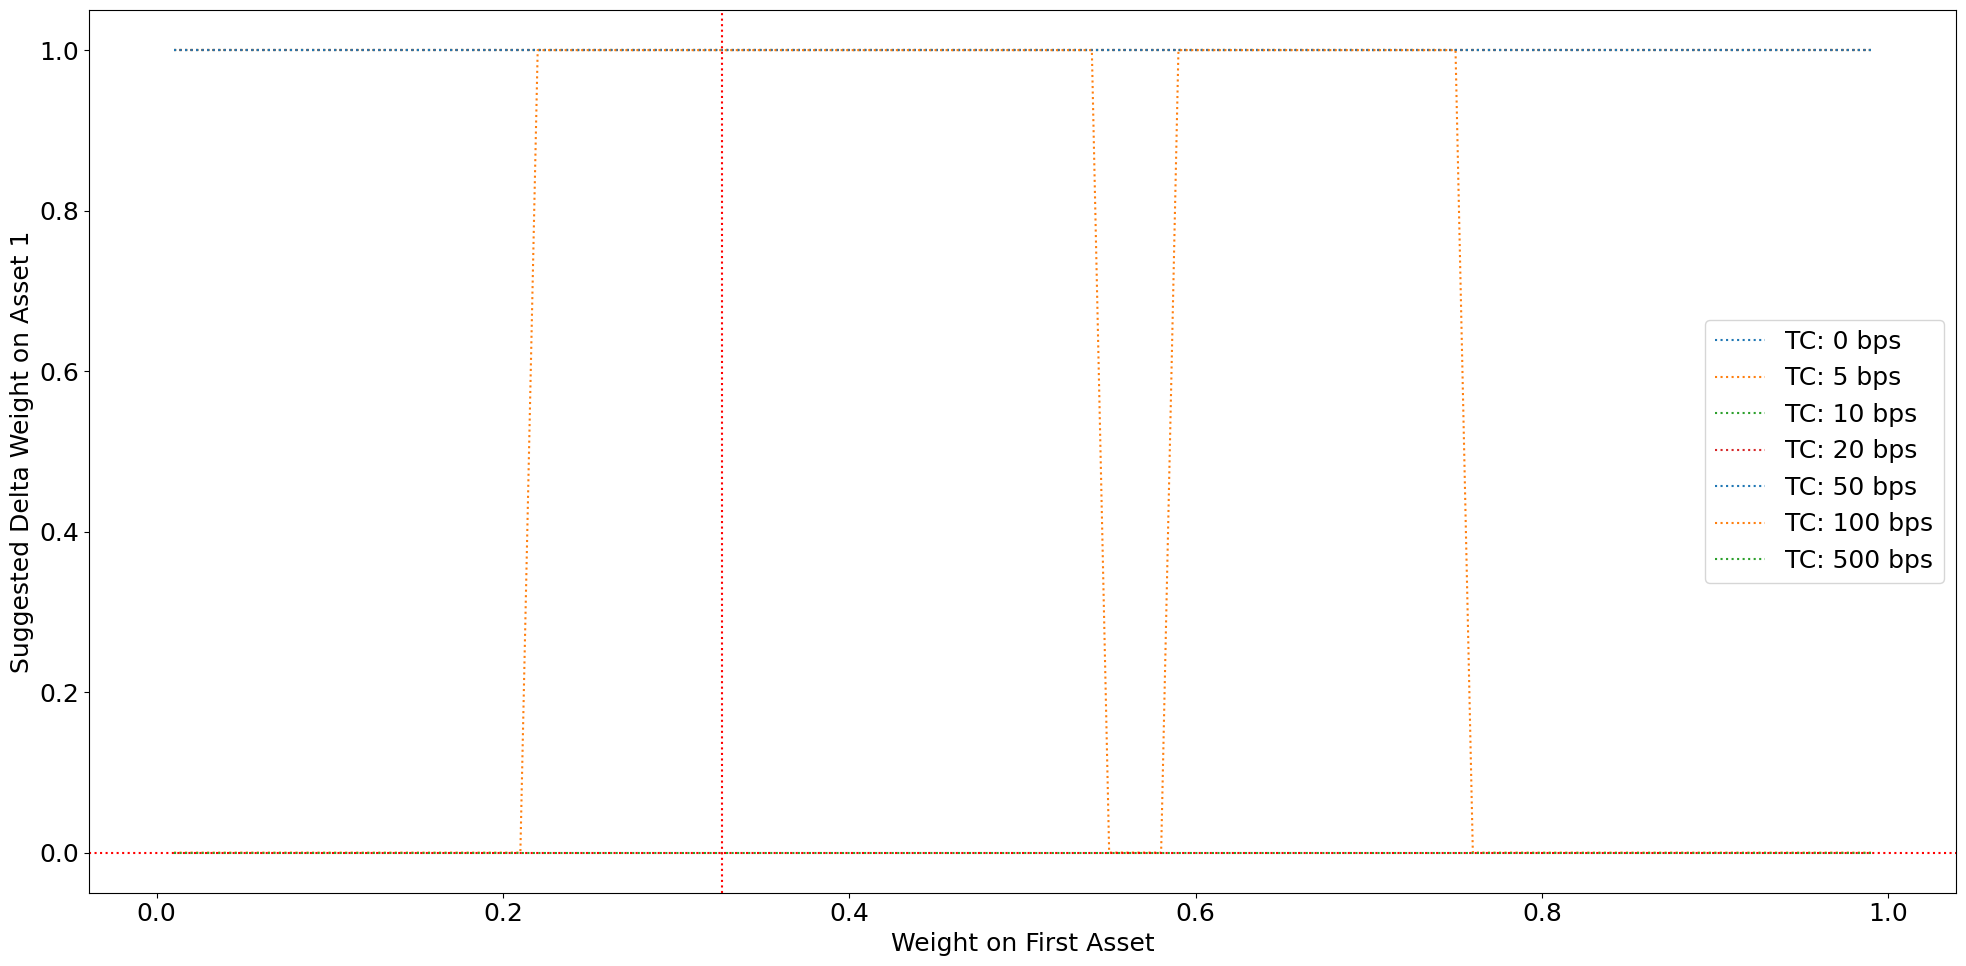

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# ql_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# bell_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
dqn_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dotted")
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()

In [23]:
def fix_reward(x):
    return [i.cpu().item() for i in x]

In [24]:
reward_df = pd.DataFrame()
for col, val in reward_dict.items():
    reward_df[col] = fix_reward(reward_dict[col])

reward_df

,0.0000,0.0005,0.0010,0.0020,0.0050,0.0100,0.0500


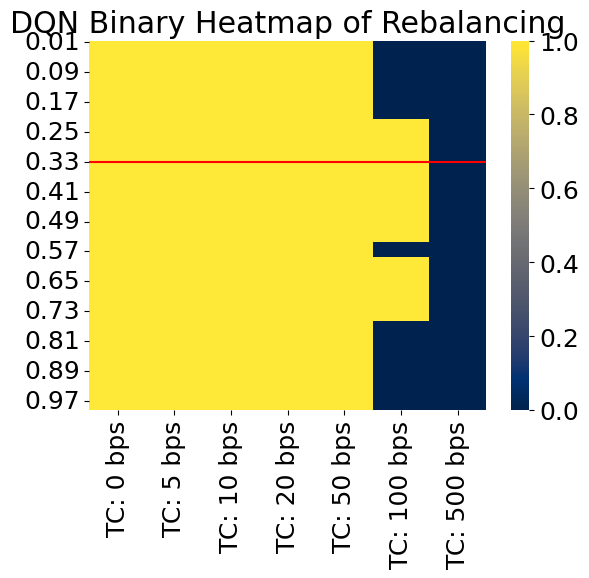

In [25]:
sns.heatmap(dqn_action_df, cmap='cividis')

y = optimal_weight[0]
ax = plt.gca()
plt.hlines(y=y*100, xmin=0, xmax=len(dqn_action_df.columns), colors='red')
plt.title("DQN Binary Heatmap of Rebalancing")
plt.show()

# DP

In [26]:
# og_path = '/Users/Roy/Desktop/College/GeorgiaTech/Research/Portfolio-Rebalancing-DQN'

In [27]:
# dp_path = og_path + '/DP_Binary/results/models/'
# os.chdir(dp_path)
# #%%

In [28]:
# #%%
# df_0 = pd.read_csv("dp_tc_0_assets_2", index_col=0, dtype=np.float32)
# df_01 = pd.read_csv("dp_tc_0.001_assets_2", index_col=0, dtype=np.float32)
# df_02 = pd.read_csv("dp_tc_0.002_assets_2", index_col=0, dtype=np.float32)
# df_05 = pd.read_csv("dp_tc_0.0005_assets_2", index_col=0, dtype=np.float32)
# df_5 = pd.read_csv("dp_tc_0.005_assets_2", index_col=0, dtype=np.float32)
# df_1 = pd.read_csv("dp_tc_0.01_assets_2", index_col=0, dtype=np.float32)
# df_5 = pd.read_csv("dp_tc_0.05_assets_2", index_col=0, dtype=np.float32)
# #%%
# df_list = [df_0, df_05, df_01, df_02, df_5, df_1, df_5]
# #%%
# x = pd.to_numeric(df_0.index.values)
# action_possible = pd.to_numeric(df_0.columns.values)
# #%%
# action_df = pd.DataFrame(index=x)
# action_bm_df = pd.DataFrame(index=x)
# for tc, bell in zip(tc_list, df_list):
#     # visualize q table
#     action = np.array([action_possible[i] for i in np.argmax(bell, axis=1)])
#     action_df[f"TC: {tc * 1e4:.0f} bps BM"] = action
#     action_bm = []
#     for i in x:
#         a = x[np.argmax([net_sharpe(np.array([j, 1 - j]), mu, cov, np.array([i, 1 - i]), tc) for j in x])] - i
#         action_bm.append(a)
#     action_bm = np.array(action_bm)
#     action_bm_df[f"TC: {tc * 1e4:.0f} bps BM (GT)"] = action_bm
# #%%
# optimal_weight = find_optimal_wgt(mu, cov)
# optimal_weight
# #%%
# fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# action_bm_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed", alpha=0.5)
# ax.set_xlabel("Weight on First Asset")
# ax.set_ylabel("Suggested Delta Weight on Asset 1")
# ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
# ax.axhline(0, color="red", linestyle="dotted")
# ax.legend()
# plt.tight_layout()
# plt.show()
# plt.close()

# #%%
# # Create subplots
# fig = sp.make_subplots(rows=1, cols=1, subplot_titles="Comparison of BM and Net Sharpe State Possible Outputs", shared_yaxes=True)

# # Add traces for Action DQN and Action BM
# for col, color, linestyle in zip(action_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['solid']*len(action_df.columns)):
#     trace_dqn = go.Scatter(x=action_df.index, y=action_df[col], mode='lines', name=f'Action BM - {col}', line=dict(color=color, dash="solid"))
#     fig.add_trace(trace_dqn, row=1, col=1)

# # Add traces for Action DQN and Action BM
# for col, color, linestyle in zip(action_bm_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['dot']*len(action_bm_df.columns)):
#     trace_bm = go.Scatter(x=action_bm_df.index, y=action_bm_df[col], mode='lines', name=f'Ground Truth - {col}', line=dict(color=color, dash=linestyle))
#     fig.add_trace(trace_bm, row=1, col=1)

# # Add vertical and horizontal lines
# fig.add_shape(dict(
#     type="line",
#     x0=optimal_weight[0],
#     x1=optimal_weight[0],
#     y0=action_df.values.min(),
#     y1=action_df.values.max(),
#     line=dict(color="gold", dash="dot")
# ))

# fig.add_shape(dict(
#     type="line",
#     x0=action_df.index.min(),
#     x1=action_df.index.max(),
#     y0=0,
#     y1=0,
#     line=dict(color="gold", dash="dot")
# ))

# # Update layout
# fig.update_layout(
#     title="Comparison of BM and Net Sharpe State Possible Outputs",
#     xaxis=dict(title="Weight on First Asset"),
#     yaxis=dict(title="Suggested Delta Weight on Asset 1"),
#     showlegend=True,
# )

# # Show the figure
# fig.show()

# #%%

In [29]:
# # Assuming `dqn_bool_action_df`, `action_df`, and `optimal_weight` are available

# # Create subplots
# fig = sp.make_subplots(rows=1, cols=1, subplot_titles=("Comparison of DQN and Action"), shared_yaxes=True)

# # Add traces for DQN and Action
# for col, color, linestyle in zip(dqn_action_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['solid']*len(dqn_action_df.columns)):
#     trace_dqn = go.Scatter(x=dqn_action_df.index, y=dqn_action_df[col], mode='lines', name=f'DQN - {col}', line=dict(color=color, dash=linestyle))
#     fig.add_trace(trace_dqn, row=1, col=1)

# # Add traces for DQN and Action
# for col, color, linestyle in zip(action_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['dash']*len(action_df.columns)):
#     trace_action = go.Scatter(x=action_df.index, y=action_df[col], mode='lines', name=f'BM - {col}', line=dict(color=color, dash=linestyle))
#     fig.add_trace(trace_action, row=1, col=1)

# # Add traces for Action DQN and Action BM
# for col, color, linestyle in zip(action_bm_df.columns, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#2a8bde', '#ff6e51', '#4caf50'], ['dot']*len(action_bm_df.columns)):
#     trace_bm = go.Scatter(x=action_bm_df.index, y=action_bm_df[col], mode='lines', name=f'Ground Truth - {col}', line=dict(color=color, dash=linestyle))
#     fig.add_trace(trace_bm, row=1, col=1)

# # Add vertical and horizontal lines
# fig.add_shape(dict(
#     type="line",
#     x0=optimal_weight[0],
#     x1=optimal_weight[0],
#     y0=action_df.values.min(),
#     y1=action_df.values.max(),
#     line=dict(color="gold", dash="dot")
# ))

# fig.add_shape(dict(
#     type="line",
#     x0=dqn_action_df.index.min(),
#     x1=dqn_action_df.index.max(),
#     y0=0,
#     y1=0,
#     line=dict(color="gold", dash="dot")
# ))

# # Update layout
# fig.update_layout(
#     title="Comparison of DQN and Action",
#     xaxis=dict(title="Weight on First Asset"),
#     yaxis=dict(title="Suggested Delta Weight on Asset 1"),
#     showlegend=True,
# )

# # Show the figure
# fig.show()

# #%%

In [30]:
# # Assuming `dqn_bool_action_df` and `bool_action_bm_df` are your DataFrames
# dqn_df = dqn_action_df.copy()
# bm_df = action_df.copy()

# # Create a heatmap trace for DQN Binary
# trace_dqn = go.Heatmap(z=dqn_df, x=dqn_df.columns, y=dqn_df.index, name="DQN Binary")

# # Create a heatmap trace for DP Bellman
# trace_dp = go.Heatmap(z=bm_df, x=bm_df.columns, y=bm_df.index, name="DP Bellman")

# # Create a heatmap trace for Q Table
# # trace_q = go.Heatmap(z=q_df, x=q_df.columns, y=q_df.index, name="Q Table")

# # Create the layout with 'overlay' parameter set to "overlay"
# layout = go.Layout(
#     title="Comparison of DQN Binary, DP Bellman, and Q Learning",
#     xaxis=dict(title="Transaction Cost (bps)",
#                showgrid=True),
#     yaxis=dict(title="Weight on First Asset",
#                showgrid=True))

# # Add horizontal line at y=0.50
# layout.shapes = [
#     dict(
#         type="line",
#         x0=dqn_df.columns[0],  # Adjust x0 to the starting point of your data
#         x1=dqn_df.columns[-1],  # Adjust x1 to the ending point of your data
#         y0=optimal_weight[0],
#         y1=optimal_weight[0],
#         line=dict(color="red", width=2),  # You can customize the color and width of the line
#     ),
#     dict(
#         type="line",
#         x0=bm_df.columns[0],  # Adjust x0 to the starting point of your data
#         x1=bm_df.columns[-1],  # Adjust x1 to the ending point of your data
#         y0=optimal_weight[0],
#         y1=optimal_weight[0],
#         line=dict(color="red", width=2),  # You can customize the color and width of the line
#     ),
#     # dict(
#     #     type="line",
#     #     x0=q_df.columns[0],  # Adjust x0 to the starting point of your data
#     #     x1=q_df.columns[-1],  # Adjust x1 to the ending point of your data
#     #     y0=optimal_weight[0],
#     #     y1=optimal_weight[0],
#     #     line=dict(color="red", width=2))
# ]

# # Create the figure
# fig = go.Figure(data=[trace_dp], layout=layout)
# fig.show()

# fig = go.Figure(data=[trace_dqn], layout=layout)
# fig.show()

# # fig = go.Figure(data=[trace_q], layout=layout)
# # fig.show()

# #%%

In [31]:
# # Create an empty dataframe to store the confusion matrices
# confusion_matrices = {}

# # Iterate through the columns and calculate confusion matrices
# for col1, col2 in zip(bm_df.columns, dqn_df.columns):
#     true_labels = bm_df[col1]
#     predicted_labels = dqn_df[col2]

#     # Create the confusion matrix
#     confusion = confusion_matrix(true_labels, predicted_labels)
#     confusion_matrices[col1] = confusion

# # Print or use the confusion matrices as needed
# for column, confusion in confusion_matrices.items():
#     print(f"Confusion Matrix for {column}:")
#     print(confusion)

# #%%
# dqn_noreb = {}
# bm_noreb = {}
# for col1, col2 in zip(bm_df.columns, dqn_df.columns):
#     bm_index = bm_df[bm_df[col1] == 0].index.values
#     dqn_index = dqn_df[dqn_df[col2] == 0].index.values
#     bm_noreb[col2] = bm_index
#     dqn_noreb[col2] = dqn_index
# #%%
# # Create a DataFrame from the dictionary, excluding keys with empty values
# df = pd.DataFrame.from_dict(dqn_noreb, orient='index').T

# # Create a box plot using Plotly
# fig = px.box(df, title="Box Plot of Data")

# # Show the plot
# fig.show()
# #%%
# # Create a DataFrame from the dictionary, excluding keys with empty values
# df = pd.DataFrame.from_dict(bm_noreb, orient='index').T

# # Create a box plot using Plotly
# fig = px.box(df, title="Box Plot of Data")

# # Show the plot
# fig.show()